In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import keras
import keras.backend as K

In [4]:
train_df = pd.read_csv('train.csv', sep=',')
test_df = pd.read_csv('test.csv', sep=',')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train_df.shape

(182080, 16)

In [6]:
train_df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [7]:
test_df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
0,p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My second grade class will really benefit from...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2
1,p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,"We do a lot of small group, where the student ...",This project is very important to my classroom...,My students need Time Magazines for next year ...,1
2,p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,These Fairy Tale Problem Solving STEM kits wil...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0
3,p233680,8e92622d2985d3faac1de71609c4be72,Mrs.,IA,2016-04-27 22:32:43,Grades PreK-2,Literacy & Language,Literacy,Classroom Library,Reading is the gateway to the soul. Guiding c...,First graders enter the classroom each day rea...,Book bins will help to organize our classroom ...,"When students begin the first grade, many are ...",My students need an organized classroom library.,0
4,p171879,91a3c89981f626d9a0d067c65fb186ce,Mr.,CA,2016-04-27 18:59:15,Grades 6-8,"Music & The Arts, Special Needs","Performing Arts, Special Needs",Reeds so we can Read,"\""Mr. Reyes! I need another reed!\"" I hear t...",We have a diverse population with almost entir...,Each day in my class students consume supplies...,My students come from very troubled homes and ...,My students need reeds to perform in class eac...,1


In [8]:
train, dev = train_test_split(train_df, random_state=123, shuffle=True, test_size = 0.1)

In [9]:
print("Training data shape:", train.shape)
print("Test data shape:", dev.shape)

Training data shape: (163872, 16)
Test data shape: (18208, 16)


In [10]:
def get_project_essay(df):
    return (df["project_essay_1"].fillna('') +
            ' ' + df["project_essay_2"].fillna('') +
            ' ' + df["project_essay_3"].fillna('') +
            ' ' + df["project_essay_4"].fillna(''))

def get_text(df):
    return df["project_title"].fillna('') + ' ' + get_project_essay(df)

In [11]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(get_text(train))

In [12]:
def preprocess_target(df):
    return df[["project_is_approved"]].copy()

def preprocess_data(df):
    processed_df = df[["teacher_number_of_previously_posted_projects"]].copy()
    processed_df["project_title"] = tokenizer.texts_to_sequences(df["project_title"])
    processed_df["project_essay"] = tokenizer.texts_to_sequences(get_project_essay(df))
    
    return processed_df

In [13]:
processed_train = preprocess_data(train)
y_train = preprocess_target(train)
print(processed_train.shape, y_train.shape)

processed_dev = preprocess_data(dev)
y_dev = preprocess_target(dev)
print(processed_dev.shape, y_dev.shape)

(163872, 3) (163872, 1)
(18208, 3) (18208, 1)


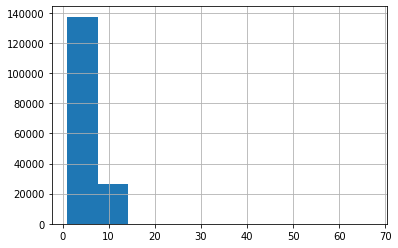

In [14]:
processed_train["project_title"].apply(lambda x: len(x)).hist(bins=10)

In [15]:
MAX_PROJECT_TITLE_SEQ_LEN = 12
MAX_PROJECT_TITLE = processed_train["project_title"].apply(lambda x: max(x) if len(x) > 0 else 0).max() + 1

MAX_PROJECT_ESSAY_SEQ_LEN = 450
MAX_PROJECT_ESSAY = processed_train["project_essay"].apply(lambda x: max(x) if len(x) > 0 else 0).max() + 1

MAX_TEXT = max([MAX_PROJECT_TITLE, MAX_PROJECT_ESSAY])

def get_keras_data(df):
    return {
        "teacher_number_of_previously_posted_projects": np.array(df["teacher_number_of_previously_posted_projects"]),
        "project_title": keras.preprocessing.sequence.pad_sequences(df["project_title"], maxlen=MAX_PROJECT_TITLE_SEQ_LEN),
        "project_essay": keras.preprocessing.sequence.pad_sequences(df["project_essay"], maxlen=MAX_PROJECT_ESSAY_SEQ_LEN),
    }

In [16]:
X_train = get_keras_data(processed_train)
X_dev = get_keras_data(processed_dev)


In [23]:
def create_rnn_model():
    teacher_number_of_previously_posted_projects = keras.layers.Input(shape=(1,), name="teacher_number_of_previously_posted_projects")
    project_title = keras.layers.Input(shape=(MAX_PROJECT_TITLE_SEQ_LEN,), name="project_title")
    project_essay = keras.layers.Input(shape=(MAX_PROJECT_ESSAY_SEQ_LEN,), name="project_essay")

    emb_layer = keras.layers.Embedding(MAX_TEXT, 50)
    emb_project_title = emb_layer(project_title)
    emb_project_essay = emb_layer(project_essay)

    rnn_project_title = keras.layers.GRU(8, activation="relu")(emb_project_title)
    rnn_project_essay = keras.layers.GRU(16, activation="relu")(emb_project_essay)
    x = keras.layers.concatenate([teacher_number_of_previously_posted_projects,
                                 rnn_project_title,
                                 rnn_project_essay,
                                 ])
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    
    return keras.models.Model(
        inputs=[teacher_number_of_previously_posted_projects,
                project_title,
                project_essay,
                #project_resource_summary,
               ],
        outputs=output)

rnn_model = create_rnn_model()
rnn_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
project_title (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
project_essay (InputLayer)      [(None, 450)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             4132100     project_title[0][0]              
                                                                 project_essay[0][0]              
__________________________________________________________________________________________________
teacher_number_of_previously_po [(None, 1)]          0                                 

In [24]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.30.8.178:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.30.8.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.30.8.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [25]:
optimizer = keras.optimizers.Adam(lr=0.001)
rnn_model.compile(optimizer=optimizer,
                  loss=keras.losses.binary_crossentropy,
                  metrics=["accuracy"])

for i in range(3):
    rnn_model.fit(X_train, y_train,
                 batch_size=(2 ** (i + 8)),
                 epochs=1,
                 validation_data=(X_dev, y_dev))

  2/641 [..............................] - ETA: 4:33 - loss: 0.9476 - accuracy: 0.2773WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.2094s). Check your callbacks.


641/641 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8368WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_test_batch_end` time: 0.0478s). Check your callbacks.


  2/321 [..............................] - ETA: 1:16 - loss: 0.3587 - accuracy: 0.8447WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_train_batch_end` time: 0.2326s). Check your callbacks.


321/321 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8521WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_test_batch_end` time: 0.0544s). Check your callbacks.


  2/161 [..............................] - ETA: 1:02 - loss: 0.3303 - accuracy: 0.8745WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0013s vs `on_train_batch_end` time: 0.3829s). Check your callbacks.


161/161 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.8666WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_test_batch_end` time: 0.1050s). Check your callbacks.


161/161 [==============================] - 66s 411ms/step - loss: 0.3331 - accuracy: 0.8666 - val_loss: 0.3798 - val_accuracy: 0.8482


In [26]:
processed_test = preprocess_data(test_df)

X_test = get_keras_data(processed_test)

preds = rnn_model.predict(X_test, batch_size=512)

submission = pd.DataFrame({
    "id": test_df["id"],
    "project_is_approved": preds.reshape(-1),
})

submission.to_csv("submission.csv", index=False)

In [28]:
res = pd.read_csv('submission.csv')
res.tail()

,id,project_is_approved
78030,p183993,0.942313
78031,p116343,0.972300
78032,p210728,0.946100
78033,p060531,0.963157
78034,p087783,0.821666
